In [ ]:
import sys
%pip install -y -c conda-forge rdkit



Note: you may need to restart the kernel to use updated packages.



Usage:   
  c:\Users\yby39\AppData\Local\Programs\Python\Python312\python.exe -m pip install [options] <requirement specifier> [package-index-options] ...
  c:\Users\yby39\AppData\Local\Programs\Python\Python312\python.exe -m pip install [options] -r <requirements file> [package-index-options] ...
  c:\Users\yby39\AppData\Local\Programs\Python\Python312\python.exe -m pip install [options] [-e] <vcs project url> ...
  c:\Users\yby39\AppData\Local\Programs\Python\Python312\python.exe -m pip install [options] [-e] <local project path> ...
  c:\Users\yby39\AppData\Local\Programs\Python\Python312\python.exe -m pip install [options] <archive url/path> ...

no such option: -y


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit import ML
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

df = pd.read_csv("../data/raw/data.csv")

print(df.isna().sum())

# Split into train/test
X = df.drop("flashpoint", axis=1)

y = df["flashpoint"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df.head()

compound          0
flashpoint        0
pure substance    0
smiles            0
source            0
is_silicon        0
is_metallic       0
is_tin            0
is_acid           0
data type         0
dtype: int64


,compound,flashpoint,pure substance,smiles,source,is_silicon,is_metallic,is_tin,is_acid,data type
0,1-aminopropan-2-ol,350.15,1,CC(CN)O,pubchem,0,0,0,0,randonly selected as training point or test point
1,"1-chloro-2,4-dinitrobenzene",467.15,1,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,pubchem,0,0,0,0,randonly selected as training point or test point
2,"1,2-dichloroethane",286.15,1,C(CCl)Cl,pubchem,0,0,0,0,randonly selected as training point or test point
3,"1,2,4-trichlorobenzene",383.15,1,C1=CC(=C(C=C1Cl)Cl)Cl,pubchem,0,0,0,0,randonly selected as training point or test point
4,2-chloroacetaldehyde,361.15,1,C(C=O)Cl,pubchem,0,0,0,0,randonly selected as training point or test point


In [8]:
print(df['data type'].value_counts())
print(df['smiles'].value_counts())
print(df['source'].value_counts())

data type
randonly selected as training point or test point    13672
training data                                          582
Non-DIPPR data                                         289
test data                                              153
Name: count, dtype: int64
smiles
Cc1ccccc1                     12
CCCCCCCC                      12
CC(C)CCO                      11
CCCCCCC                       11
CCCCC                         11
                              ..
Nc1ccc(Oc2ccc(N)cc2)cc1        1
CC(N)=O                        1
Nc1ccccn1                      1
CC(C)(C)c1cccc(C(C)(C)C)n1     1
C(CCl)O                        1
Name: count, Length: 10230, dtype: int64
source
le15                     8843
pubchem                  1741
carroll11                 937
katritzky07               739
hazardous materials       364
carroll10                 292
mathieu14                 289
patel10                   234
chen14                    211
mathieu12                 210
wang11    

In [ ]:
# Update train-test split with processed features

# Replace original X with processed features
X = processed_features
y = df["flashpoint"]

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save processed datasets
X_train.to_csv("../data/processed/X_train.csv", index=False)
y_train.to_csv("../data/processed/y_train.csv", index=False)
X_test.to_csv("../data/processed/X_test.csv", index=False)
y_test.to_csv("../data/processed/y_test.csv", index=False)

print("Processed datasets saved successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Data Analysis and Feature Engineering Approach

Our dataset contains multiple features that have string values, we need to convert them to numerical values:

I. **SMILES strings** - These represent molecular structures and can be converted to molecular descriptors using RDKit
(RDKit is an open-source toolkit for cheminformatics and machine learning)

II. **Categorical features** - Need to be encoded using techniques like one-hot encoding or label encoding


Lets start by visualising some molecules (optional) to test some of RDKit features

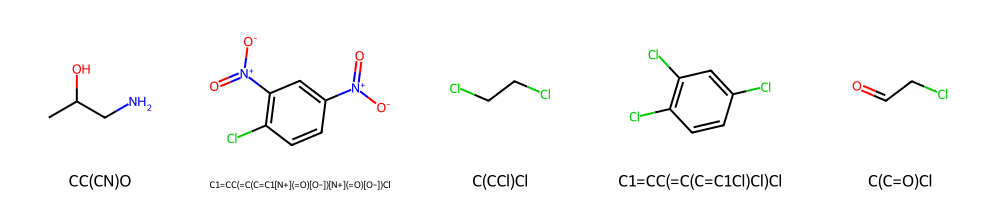

In [4]:
from rdkit.Chem import Draw

smiles_values = df['smiles'].head(5).tolist()
# Draw the first 5 SMILES strings
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_values]
img= Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=smiles_values)
img

In [14]:
def calculate_molecular_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Calculate basic molecular descriptors
            descriptors = {
                'MolWt': Descriptors.MolWt(mol),                    # Molecular weight
                'LogP': Descriptors.MolLogP(mol),                   # Octanol-water partition coefficient
                'NumHDonors': Descriptors.NumHDonors(mol),          # Number of H-bond donors
                'NumHAcceptors': Descriptors.NumHAcceptors(mol),    # Number of H-bond acceptors
                'NumRotatableBonds': Descriptors.NumRotatableBonds(mol), # Number of rotatable bonds
                'NumAromaticRings': Descriptors.NumAromaticRings(mol),   # Number of aromatic rings
                'TPSA': Descriptors.TPSA(mol)                       # Topological polar surface area
            }
            
            # Calculate Morgan fingerprints (ECFP)
            fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
            fingerprint_features = np.zeros((1,))
            # Convert the fingerprint to a numpy array
            DataStructs = Chem.DataStructs
            DataStructs.ConvertToNumpyArray(fingerprint, fingerprint_features)
            
            return pd.Series(descriptors), fingerprint_features
        else:
            return pd.Series({desc: np.nan for desc in ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 
                                                       'NumRotatableBonds', 'NumAromaticRings', 'TPSA']}), None
    except:
        return pd.Series({desc: np.nan for desc in ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 
                                                  'NumRotatableBonds', 'NumAromaticRings', 'TPSA']}), None


In [18]:
# Apply the function to the SMILES column
descriptors_df = pd.DataFrame()
fingerprints = []

# Process SMILES strings in batches to avoid memory issues
for i in range(0, len(df), 100):
    batch = df.iloc[i:i+100]
    batch_descriptors = []
    batch_fingerprints = []
    
    for smiles in batch['smiles']:
        desc, fp = calculate_molecular_descriptors(smiles)
        batch_descriptors.append(desc)
        if fp is not None:
            batch_fingerprints.append(fp)
        else:
            batch_fingerprints.append(np.zeros(1024))
            
    descriptors_df = pd.concat([descriptors_df, pd.DataFrame(batch_descriptors).reset_index(drop=True)])
    fingerprints.extend(batch_fingerprints)

# Reset index for the descriptors dataframe
descriptors_df = descriptors_df.reset_index(drop=True)

#  the fingerprints as a DataFrame
fingerprints_df = pd.DataFrame(fingerprints, columns=[f'FP_{i}' for i in range(1024)])

# Display the molecular descriptors
descriptors_df.head()

,MolWt,LogP,NumHDonors,NumHAcceptors,NumRotatableBonds,NumAromaticRings,TPSA
0,75.111,-0.6741,2.0,2.0,1.0,0.0,46.25
1,202.553,2.1564,0.0,4.0,2.0,1.0,86.28
2,98.960,1.4640,0.0,0.0,1.0,0.0,0.00
3,181.449,3.6468,0.0,0.0,0.0,1.0,0.00
4,78.498,0.4241,0.0,1.0,1.0,0.0,17.07


In [ ]:
# Process categorical features

# 1. Handle 'data type' using one-hot encoding
encoder = OneHotEncoder(sparse_output=False, drop='first')
data_type_encoded = encoder.fit_transform(df[['data type']])
data_type_df = pd.DataFrame(data_type_encoded, columns=[f'data_type_{cat}' for cat in encoder.categories_[0][1:]])

# 2. Handle 'source' using one-hot encoding if it has few categories
if df['source'].nunique() < 10:  # Use one-hot if there are few categories
    source_encoder = OneHotEncoder(sparse_output=False, drop='first')
    source_encoded = source_encoder.fit_transform(df[['source']])
    source_df = pd.DataFrame(source_encoded, columns=[f'source_{cat}' for cat in source_encoder.categories_[0][1:]])
else:  # Use label encoding if there are many categories
    le = LabelEncoder()
    df['source_encoded'] = le.fit_transform(df['source'])
    source_df = df[['source_encoded']]

# Display encoded categorical features
print("One-hot encoded 'data type' feature:")
print(data_type_df.head())

# Show the source encoding
print("\nEncoded 'source' feature:")
print(source_df.head())

In [ ]:
# Combine all features

# Combine original numerical features with processed features
numerical_features = df[['is_silicon', 'is_metallic', 'is_tin', 'is_acid']]

# Combine all features into one dataframe
processed_features = pd.concat([numerical_features.reset_index(drop=True), 
                               descriptors_df.reset_index(drop=True),
                               data_type_df.reset_index(drop=True),
                               source_df.reset_index(drop=True)], axis=1)

# Print the shape of the processed features
print(f"Original dataframe shape: {df.shape}")
print(f"Processed features shape: {processed_features.shape}")

# Display the first few rows of the processed features
processed_features.head()

# Feature Engineering Summary

We've successfully converted all the string and categorical data to numerical features:

1. **SMILES strings** → Molecular descriptors and fingerprints using RDKit
2. **Categorical features** → One-hot encoded or label encoded
3. **Binary features** → Already in numerical format (0/1)

The resulting feature matrix can now be used for training machine learning models to predict flashpoint values.

In [ ]:
# Feature importance analysis (optional)

# Check for missing values in processed features
print("Missing values in processed features:")
print(processed_features.isna().sum().sum())

# Fill missing values if any
if processed_features.isna().sum().sum() > 0:
    # For demonstration, we'll use simple imputation with mean
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    processed_features_imputed = pd.DataFrame(
        imputer.fit_transform(processed_features),
        columns=processed_features.columns
    )
    processed_features = processed_features_imputed

# Quick feature importance check with a Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# Train a simple model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(15)

# Plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()